# Package Imports

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#  Data dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split

#  Get Data from GDrive

In [0]:
#  Authenticate Google Account for GDrive access (raw data is saved in GDrive)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Raw data file gdrive location: 1n3_bCYonqpT-me4g7v7TlO80PVbaV9HR
clean_data_downloaded = drive.CreateFile({'id': '1n3_bCYonqpT-me4g7v7TlO80PVbaV9HR'})
clean_data_downloaded.GetContentFile('cleanData2.csv')

df_cleanData = pd.read_csv('cleanData2.csv', usecols=['Ticket number', 'Issue Date', 'Issue time', 'RP State Plate', 'Make', 'Body Style', 'Color', 'Location', 'Route', 'Agency', 'Violation code', 'Violation Description', 'Fine amount', 'Issue_Hour', 'Issue_Year', 'Issue_Month','Issue_Month_Year', 'Issue_Weekday', 'Modified_Location'], dtype={'Ticket number': str})

#  Data Assessment

In [4]:
df_cleanData.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,12.0,2015,12,2015-12,Monday,WELBY WAY
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,20.0,2015,12,2015-12,Monday,WORLD WAY
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,15.0,2015,12,2015-12,Saturday,WORLD WAY
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,GEORGIA ST OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,1.0,2015,9,2015-09,Tuesday,GEORGIA ST OLYMPIC


In [5]:
df_cleanData.shape

(6751096, 19)

In [6]:
df_cleanData.Modified_Location.nunique()

86703

In [7]:
df_cleanData.Modified_Location.value_counts()

 VENTURA BL               131384
 WALL ST S                 45709
 MAIN ST S                 43305
 SAN VICENTE BL            38858
 PICO BL W                 37085
 RD ST W                   34097
 LOS ANGELES ST S          33986
 HOPE ST S                 31930
 SUNSET BL                 31738
 LARCHMONT BL N            31316
 ST ST W                   27419
 SANTEE ST S               27172
 SAN PEDRO ST S            26956
 MAPLE AVE S               26730
 WILSHIRE BLVD             25227
 FIGUEROA ST S             25182
 SPRING ST S               22947
 MELROSE AV                22325
 RD ST E                   22145
 HOLLYWOOD BLVD            22104
 ORANGE DR N               21671
 ABBOT KINNEY BLVD         21142
 HILL ST S                 20156
 FIGUEROA ST N             19594
 MIDVALE AVE               19105
 AVENUE  N                 18988
 WESTWOOD BLVD             18580
 SYCAMORE AVE N            17472
 ST ST E                   16877
 WESTWOOD BL               16738
          

In [10]:
df_cleanData[df_cleanData.Modified_Location.str.contains('BARRY AVE', na=False)]

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location
1040,4272633772,2015-12-30T00:00:00,1651.0,CA,HYUN,PA,GY,1267 BARRY AVE,00901,51.0,80.56E4+,RED ZONE,93.0,16.0,2015,12,2015-12,Wednesday,BARRY AVE
3682,4273760654,2015-12-30T00:00:00,846.0,CA,MERZ,PA,WT,1405 BARRY AVENUE,00152,51.0,22500F,PARKED ON SIDEWALK,68.0,8.0,2015,12,2015-12,Wednesday,BARRY AVENUE
3683,4273760665,2015-12-30T00:00:00,847.0,CA,MERZ,PA,WT,1405 BARRY AVENUE,00152,51.0,5204A-,DISPLAY OF TABS,25.0,8.0,2015,12,2015-12,Wednesday,BARRY AVENUE
3686,4273760691,2015-12-30T00:00:00,1154.0,CA,TSMR,PA,RD,2007 BARRY AVE,00152,51.0,80.58L,PREFERENTIAL PARKING,68.0,11.0,2015,12,2015-12,Wednesday,BARRY AVE
4291,4273924701,2015-12-30T00:00:00,612.0,CA,PONT,PA,WT,1459 BARRY AVENUE,00119,51.0,5200,DISPLAY OF PLATES,25.0,6.0,2015,12,2015-12,Wednesday,BARRY AVENUE
5045,4274106970,2015-12-30T00:00:00,618.0,CA,CHEV,PA,BK,1323 BARRY AVE,00113,51.0,5200,DISPLAY OF PLATES,25.0,6.0,2015,12,2015-12,Wednesday,BARRY AVE
8320,4273508385,2015-12-31T00:00:00,52.0,CA,TOYT,PA,BK,1616 BARRY AVE,00113,51.0,5204A-,DISPLAY OF TABS,25.0,0.0,2015,12,2015-12,Thursday,BARRY AVE
8330,4273508481,2015-12-31T00:00:00,610.0,CA,BMW,PA,BK,1239 BARRY AVE,00113,51.0,5200,DISPLAY OF PLATES,25.0,6.0,2015,12,2015-12,Thursday,BARRY AVE
8331,4273508492,2015-12-31T00:00:00,612.0,CA,BMW,PA,BK,1239 BARRY AVE,00113,51.0,5204A-,DISPLAY OF TABS,25.0,6.0,2015,12,2015-12,Thursday,BARRY AVE
8410,4273548882,2015-12-31T00:00:00,606.0,CA,ACUR,PA,BK,1280 BARRY AVE,00119,51.0,5204A-,DISPLAY OF TABS,25.0,6.0,2015,12,2015-12,Thursday,BARRY AVE


In [0]:
#  Replace AVENUE --> AVE
df_cleanData.Modified_Location = df_cleanData.Modified_Location.str.replace('AVENUE', 'AVE')



In [14]:
#  Check that 'AVENUE' is updated to 'AVE'
df_cleanData[df_cleanData.Modified_Location.str.contains('BARRY AVE', na=False)]

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location
1040,4272633772,2015-12-30T00:00:00,1651.0,CA,HYUN,PA,GY,1267 BARRY AVE,00901,51.0,80.56E4+,RED ZONE,93.0,16.0,2015,12,2015-12,Wednesday,BARRY AVE
3682,4273760654,2015-12-30T00:00:00,846.0,CA,MERZ,PA,WT,1405 BARRY AVENUE,00152,51.0,22500F,PARKED ON SIDEWALK,68.0,8.0,2015,12,2015-12,Wednesday,BARRY AVE
3683,4273760665,2015-12-30T00:00:00,847.0,CA,MERZ,PA,WT,1405 BARRY AVENUE,00152,51.0,5204A-,DISPLAY OF TABS,25.0,8.0,2015,12,2015-12,Wednesday,BARRY AVE
3686,4273760691,2015-12-30T00:00:00,1154.0,CA,TSMR,PA,RD,2007 BARRY AVE,00152,51.0,80.58L,PREFERENTIAL PARKING,68.0,11.0,2015,12,2015-12,Wednesday,BARRY AVE
4291,4273924701,2015-12-30T00:00:00,612.0,CA,PONT,PA,WT,1459 BARRY AVENUE,00119,51.0,5200,DISPLAY OF PLATES,25.0,6.0,2015,12,2015-12,Wednesday,BARRY AVE
5045,4274106970,2015-12-30T00:00:00,618.0,CA,CHEV,PA,BK,1323 BARRY AVE,00113,51.0,5200,DISPLAY OF PLATES,25.0,6.0,2015,12,2015-12,Wednesday,BARRY AVE
8320,4273508385,2015-12-31T00:00:00,52.0,CA,TOYT,PA,BK,1616 BARRY AVE,00113,51.0,5204A-,DISPLAY OF TABS,25.0,0.0,2015,12,2015-12,Thursday,BARRY AVE
8330,4273508481,2015-12-31T00:00:00,610.0,CA,BMW,PA,BK,1239 BARRY AVE,00113,51.0,5200,DISPLAY OF PLATES,25.0,6.0,2015,12,2015-12,Thursday,BARRY AVE
8331,4273508492,2015-12-31T00:00:00,612.0,CA,BMW,PA,BK,1239 BARRY AVE,00113,51.0,5204A-,DISPLAY OF TABS,25.0,6.0,2015,12,2015-12,Thursday,BARRY AVE
8410,4273548882,2015-12-31T00:00:00,606.0,CA,ACUR,PA,BK,1280 BARRY AVE,00119,51.0,5204A-,DISPLAY OF TABS,25.0,6.0,2015,12,2015-12,Thursday,BARRY AVE


In [0]:
#  Replace STREET --> ST
df_cleanData.Modified_Location = df_cleanData.Modified_Location.str.replace('STREET', 'ST')

In [0]:
#  Remove left side white space
df_cleanData.Modified_Location = df_cleanData.Modified_Location.str.strip()

In [17]:
#  Remove 'Location' column
df_cleanData.shape

(6751096, 19)

In [0]:
df_cleanData.drop('Location', axis=1, inplace=True)

In [19]:
df_cleanData.shape

(6751096, 18)

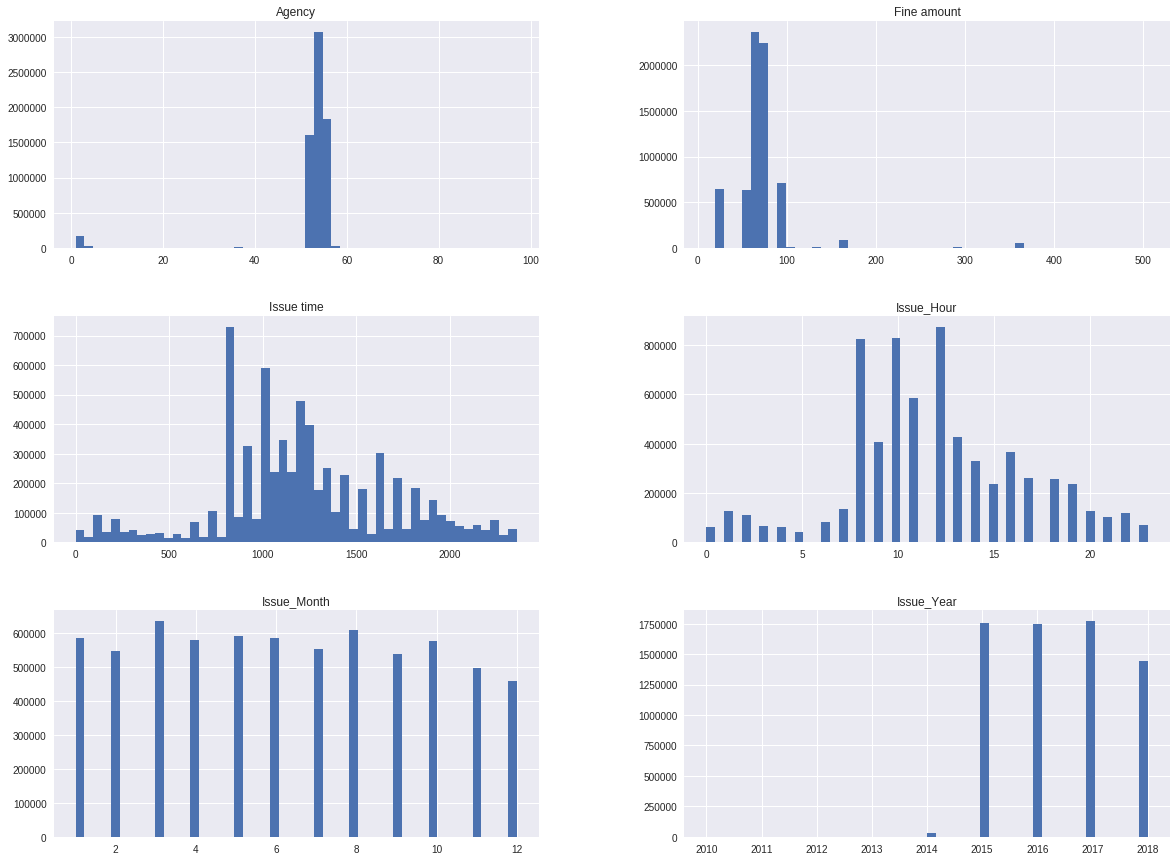

In [20]:
#  Create histograms of datafields
%matplotlib inline
import matplotlib.pyplot as plt

df_cleanData.hist(bins=50, figsize=(20, 15))
plt.show()

In [21]:
#  Assess Issue_Hour
df_cleanData.Issue_Hour.describe()

count    6.751096e+06
mean     1.185939e+01
std      4.685513e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.200000e+01
75%      1.500000e+01
max      2.300000e+01
Name: Issue_Hour, dtype: float64

In [30]:
df_cleanData.Modified_Location.value_counts()

VENTURA BL              131390
WALL ST S                45716
MAIN ST S                43312
SAN VICENTE BL           38859
PICO BL W                37106
RD ST W                  34105
LOS ANGELES ST S         33988
HOPE ST S                31931
SUNSET BL                31791
LARCHMONT BL N           31378
ST ST W                  27422
SANTEE ST S              27177
SAN PEDRO ST S           27022
MAPLE AVE S              26733
WILSHIRE BLVD            25229
FIGUEROA ST S            25186
SPRING ST S              22948
MELROSE AV               22332
RD ST E                  22149
HOLLYWOOD BLVD           22113
ORANGE DR N              21672
AVE  N                   21271
ABBOT KINNEY BLVD        21143
MIDVALE AVE              20933
HILL ST S                20199
FIGUEROA ST N            19594
PACIFIC AVE              18766
WESTWOOD BLVD            18581
IVAR AVE                 18578
SYCAMORE AVE N           17474
                         ...  
APPX  EUCLID AVE             1
ARROYO S

In [0]:
#  ADD FREQUENCY column
df_cleanData['Location_Frequency'] = df_cleanData.groupby('Modified_Location')['Modified_Location'].transform('count')

In [34]:
df_cleanData.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Route,Agency,Violation code,Violation Description,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location,high_risk,Location_Frequency
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,12.0,2015,12,2015-12,Monday,WELBY WAY,high_risk,447.0
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST,high_risk,977.0
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,2R2,2.0,8939,WHITE CURB,58.0,20.0,2015,12,2015-12,Monday,WORLD WAY,high_risk,12260.0
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,2F11,2.0,000,17104h,NaN,15.0,2015,12,2015-12,Saturday,WORLD WAY,high_risk,12260.0
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,1.0,2015,9,2015-09,Tuesday,GEORGIA ST OLYMPIC,high_risk,5.0


In [35]:
df_cleanData.Location_Frequency.describe()

count    6.751042e+06
mean     9.676271e+03
std      1.943812e+04
min      1.000000e+00
25%      1.182000e+03
50%      4.031000e+03
75%      9.858000e+03
max      1.313900e+05
Name: Location_Frequency, dtype: float64

In [0]:
def conditions(s):
  if(s['Location_Frequency'] > 1001):
    return 2
  elif(s['Location_Frequency'] > 501):
    return 1
  else:
    return 0

In [0]:
df_cleanData['t_risk_level'] = df_cleanData.apply(conditions, axis=1)

In [41]:
df_cleanData.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Route,Agency,Violation code,...,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location,high_risk,Location_Frequency,t_risk_level
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,01521,1.0,4000A1,...,50.0,12.0,2015,12,2015-12,Monday,WELBY WAY,high_risk,447.0,0
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,1C51,1.0,4000A1,...,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST,high_risk,977.0,1
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,2R2,2.0,8939,...,58.0,20.0,2015,12,2015-12,Monday,WORLD WAY,high_risk,12260.0,2
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,2F11,2.0,000,...,NaN,15.0,2015,12,2015-12,Saturday,WORLD WAY,high_risk,12260.0,2
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,1FB70,1.0,8069A,...,93.0,1.0,2015,9,2015-09,Tuesday,GEORGIA ST OLYMPIC,high_risk,5.0,0


In [42]:
df_cleanData.t_risk_level.value_counts()

2    5243335
0     996474
1     511287
Name: t_risk_level, dtype: int64

# Label Encoding

In [0]:
from sklearn import preprocessing

In [60]:
#  Encode the time_hour
df_cleanData.Issue_Hour.value_counts()
#encoder = preprocessing.LabelEncoder()
#encoder.fit(df_cleanData['Modified_Location'])
#encoder.fit(df_cleanData['Modified_Location'])
#df_cleanData[df_cleanData.Modified_Location.str.contains('<', na=False)]

12.0    874969
10.0    827393
8.0     825445
11.0    585502
13.0    427176
9.0     408384
16.0    368112
14.0    331170
17.0    260771
18.0    258001
19.0    236390
15.0    236309
7.0     136746
1.0     127918
20.0    126555
22.0    118046
2.0     112395
21.0    101462
6.0      82604
23.0     71899
3.0      68004
0.0      62328
4.0      61504
5.0      42013
Name: Issue_Hour, dtype: int64

In [68]:
df_cleanData.Issue_Hour.describe()

count    6.751096e+06
mean     1.185939e+01
std      4.685513e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.200000e+01
75%      1.500000e+01
max      2.300000e+01
Name: Issue_Hour, dtype: float64

In [0]:
Issue_Hour_Dummies = pd.get_dummies(df_cleanData.Issue_Hour, prefix='Issue_Hour').iloc[:, 1:]

In [0]:
df_cleanData = pd.concat([df_cleanData, Issue_Hour_Dummies], axis=1)

In [75]:
df_cleanData.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Route,Agency,Violation code,...,Issue_Hour_14.0,Issue_Hour_15.0,Issue_Hour_16.0,Issue_Hour_17.0,Issue_Hour_18.0,Issue_Hour_19.0,Issue_Hour_20.0,Issue_Hour_21.0,Issue_Hour_22.0,Issue_Hour_23.0
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,01521,1.0,4000A1,...,0,0,0,0,0,0,0,0,0,0
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,1C51,1.0,4000A1,...,1,0,0,0,0,0,0,0,0,0
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,2R2,2.0,8939,...,0,0,0,0,0,0,1,0,0,0
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,2F11,2.0,000,...,0,1,0,0,0,0,0,0,0,0
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,1FB70,1.0,8069A,...,0,0,0,0,0,0,0,0,0,0


Encode Location

In [0]:
le = preprocessing.LabelEncoder()

In [0]:
df_cleanData['Modified_Location_Encode'] = le.fit_transform(df_cleanData['Modified_Location'].astype(str))

In [80]:
df_cleanData.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Route,Agency,Violation code,...,Issue_Hour_15.0,Issue_Hour_16.0,Issue_Hour_17.0,Issue_Hour_18.0,Issue_Hour_19.0,Issue_Hour_20.0,Issue_Hour_21.0,Issue_Hour_22.0,Issue_Hour_23.0,Modified_Location_Encode
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,01521,1.0,4000A1,...,0,0,0,0,0,0,0,0,0,74217
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,1C51,1.0,4000A1,...,0,0,0,0,0,0,0,0,0,59699
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,2R2,2.0,8939,...,0,0,0,0,0,1,0,0,0,76527
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,2F11,2.0,000,...,1,0,0,0,0,0,0,0,0,76527
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,1FB70,1.0,8069A,...,0,0,0,0,0,0,0,0,0,31760


In [81]:
df_cleanData.Modified_Location_Encode.value_counts()

69054    131390
73696     45716
40543     43312
62345     38859
51825     37106
54992     34105
39758     33988
34832     31931
66254     31791
38255     31378
65475     27422
62624     27177
62323     27022
40918     26733
75815     25229
30118     25186
64853     22948
42094     22332
54820     22149
34506     22113
49632     21672
10470     21271
4262      21143
42489     20933
34131     20199
30102     19594
50297     18766
75113     18581
35814     18578
66618     17474
          ...  
7758          1
20036         1
38312         1
32004         1
50594         1
54688         1
68133         1
72231         1
6662          1
64027         1
66971         1
58784         1
17843         1
60694         1
66972         1
48731         1
6663          1
64788         1
5561          1
31243         1
56592         1
3338          1
42415         1
46509         1
34219         1
32322         1
58791         1
62885         1
47635         1
46198         1
Name: Modified_Location_

In [83]:
len(df_cleanData.Modified_Location_Encode.unique().tolist())

77558

In [84]:
len(df_cleanData.Modified_Location.unique().tolist())

77558

#  Can we predict the risk of a street given their measurements?

In [0]:
import pandas as pd
# define X and y
feature_cols = ['Modified_Location_Encode', 'Issue_Hour', 't_risk_level']
X = df_cleanData[feature_cols]
y = df_cleanData.t_risk_level

In [0]:
#  split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [90]:
#  train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#  Data Preparation

In [0]:
#  add new column to dataframe: 'Risk_Level'
df_cleanData['high_risk'] = 'high_risk'
# df_cleanData.rename(columns={'Risk_Level': 'high_risk'}, inplace=True)

In [23]:
df_cleanData.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Route,Agency,Violation code,Violation Description,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location,high_risk
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,12.0,2015,12,2015-12,Monday,WELBY WAY,high_risk
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST,high_risk
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,2R2,2.0,8939,WHITE CURB,58.0,20.0,2015,12,2015-12,Monday,WORLD WAY,high_risk
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,2F11,2.0,000,17104h,NaN,15.0,2015,12,2015-12,Saturday,WORLD WAY,high_risk
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,1.0,2015,9,2015-09,Tuesday,GEORGIA ST OLYMPIC,high_risk


In [24]:
df_cleanData.dtypes

Ticket number             object
Issue Date                object
Issue time               float64
RP State Plate            object
Make                      object
Body Style                object
Color                     object
Route                     object
Agency                   float64
Violation code            object
Violation Description     object
Fine amount              float64
Issue_Hour               float64
Issue_Year                 int64
Issue_Month                int64
Issue_Month_Year          object
Issue_Weekday             object
Modified_Location         object
high_risk                 object
dtype: object

# Learning Models 

In [0]:
#  Imports and Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [0]:
target_name = 'high_risk'
X = df_cleanData.drop('high_risk', axis=1)
#robust_scaler = RobustScaler()
#X = robust_scaler.fit_transform(X)
y = df_cleanData[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [0]:
#  Confusion matrix --> table that used to describe the performance of the classification model 
def CMatrix(CM, labels=['high_risk', 'low_risk']):
  df = pd.DataFrame(data=CM, index=labels, columns=labels)
  df.index.name='TRUE'
  df.columns.name='PREDICTION'
  df.loc['Total'].df.sum()
  df['Total']=df.sum(axis=1)
  return df

#  Prepare Model Analysis' Dataframe

In [0]:
#  Evaluation metrics' dataframe
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],
                      columns=['NULL', 'LogisticReg', 'ClassTree', 'NaiveBayes'])

#  The Null Model:  Always predict the most common category (doesn't work)

In [0]:
#y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
#metrics.loc['accuracy','NULL']=accuracy_score(y_pred=y_pred_test, y_true=y_test)
#metrics.loc['precision', 'NULL']=precision_score(y_pred=y_pred_test, y_true=y_test)
#metrics.loc['recall', 'NULL']=recall_score(y_pred=y_pred_test, y_true=y_test)

#CM=confusion_matrix(y_pred=y_pred_test, y_true=y_test)
#CMatrix(CM)

#  A. Logistic Regression

In [0]:
#  1) Import the estimator object (model)
#from sklearn.linear_model import LogisticRegression

#  2)  Create an instance of the estimator
#logistic_regression = LogisticRegression(n_jobs=-1, random_state=42)

#  3)  Use the training data to train the estimator
#logistic_regression.fit(X_train, y_train)

#  4)  Evaluate the model
#y_pred_test = logistic_regression.predict(X_test)
#metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
#metrics.loc['precision', 'LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
#metrics.loc['recall', 'LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

#  Confusion matrix
#CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
#CMatrix(CM)

#  B.  Classification Trees

In [29]:
#  1)  Import the estimator object (model)
from sklearn.tree import DecisionTreeClassifier

#  2)  Create an instance of the estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

#  3)  Use the training data to train the estimator
class_tree.fit(X_train, y_train)


ValueError: ignored